# Non-linear Regression

This is a general code for performing non-linear regression to a dataset.

The "model" being fit here is:

$$ r = \frac{\beta_1 \cdot C_B - C_C / \beta_5}{1+\beta_2 \cdot C_A + \beta_3 \cdot C_B + \beta_4 \cdot C_C}$$

The "x" input values are $C_A$, $C_B$, and $C_C$. Here we have lists of these values - each entry is for a different reaction. **Technically** we are fitting **initial** rates with **initial** concentrations here.

The "y" output we are fitting is $r$.

The parameters we are actually fitting are the $\beta_i$ values.

In [1]:
##### 1. Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats.distributions import t as tdist

In [2]:
##### 2. Model
def model(x,*parameters):
    
    # Indepdendent variables
    CA = x[0,:]
    CB = x[1,:]
    CC = x[2,:]
    ndtps = len(CA)
    
    # Parameters to be fit
    b1 = parameters[0]
    b2 = parameters[1]
    b3 = parameters[2]
    b4 = parameters[3]
    b5 = parameters[4]
    
    # Calculate output value for each data point based on a model
    rate_model = np.zeros(ndpts)
    for i in range(ndpts):
        rate_model[i] = (b1*CB[i]-CC[i]/b5)/(1+b2*CA[i]+b3*CB[i]+b4*CC[i])  # Manually write the rate expression
    return rate_model

In [3]:
##### 3. Enter fitting data

rate_exp = [8.55,3.79,4.82,0.02,2.75,14.39,2.54,4.35,13,8.5,0.05,11.32,3.13]
CA_exp = [470,285,470,470,470,100,100,470,100,100,100,285,285]
CB_exp = [300,80,300,80,80,190,80,190,300,300,80,300,190]
CC_exp = [10,10,120,120,10,10,65,65,54,120,120,10,120]

ndpts = len(rate_exp)

In [4]:
## Run fitting algorithm

# Parameter guesses
b1_g = 1
b2_g = 0.1
b3_g = 0.1
b4_g = 0.1
b5_g = 1
guess = [b1_g,b2_g,b3_g,b4_g,b5_g]
npars = len(guess)

# Regression
xvars = np.array([CA_exp,CB_exp,CC_exp])
popt,pcov = curve_fit(model,xvars,rate_exp,guess,method='lm')

# Confidence intervals
alpha = 0.05 # 95% confidence interval
dof = max(0,ndpts-npars) # number of degrees of freedom

tval = tdist.ppf(1.0-alpha/2.0,dof) # student t value for the dof and confidence level

ci = np.zeros([npars,2])
for i,p,var in zip(range(ndpts),popt,np.diag(pcov)):
    sigma = var**0.5
    ci[i,:] = [p-sigma*tval,p+sigma*tval]
ci_width = ci[:,1]-ci[:,0]

# Create output dataframe
param_names = ['b1','b2','b3','b4','b5']
b1,b2,b3,b4,b5 = popt
soln = pd.DataFrame(popt,index=param_names,columns=['Value'])
soln['95% CI Half Width'] = ci_width/2
soln['95% CI Half Width Rel %'] = ci_width/2/popt*100

# Generate matrix containing simulated rates and calculate the sum of squared residuals (ssr)
rate_predict = np.zeros(ndpts)
ssr = 0
for i in range(ndpts):
    rate_predict[i]=(b1*CB_exp[i]-CC_exp[i]/b5)/(1+b2*CA_exp[i]+b3*CB_exp[i]+b4*CC_exp[i])
    sqr_resid = (rate_predict[i]-rate_exp[i])**2
    ssr = ssr + sqr_resid
print('SSR = ' + "{:.3e}".format(ssr))

pd.options.display.float_format = "{:,.3f}".format
print('\n', soln, '\n')


SSR = 2.989e-01

     Value  95% CI Half Width  95% CI Half Width Rel %
b1  1.253              2.000                  159.633
b2  0.063              0.100                  160.033
b3  0.040              0.071                  177.858
b4  0.112              0.173                  154.188
b5  1.191              1.929                  161.948 



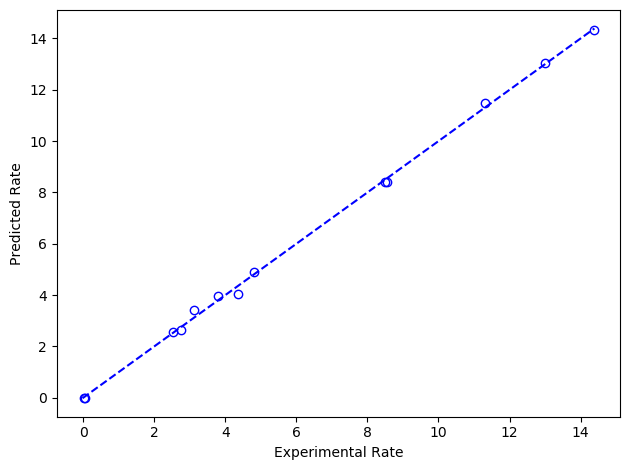

In [5]:
## Parity plots

# Parity line
x_parity = [min([min(rate_exp),min(rate_predict)]),max([max(rate_exp),max(rate_predict)])]
y_parity = [min([min(rate_exp),min(rate_predict)]),max([max(rate_exp),max(rate_predict)])]
    
# Plot data
fig = plt.figure()
ax1 = plt.subplot(111)

ax1.plot(rate_exp,rate_predict,'ob',mfc='none')
ax1.plot(x_parity,y_parity,'--b')
ax1.set_xlabel('Experimental Rate')
ax1.set_ylabel('Predicted Rate')

fig.tight_layout()

plt.show()

## Batch reactor conversion fitting

Used to fit oxidation data with initial transient


        Value  95% CI Half Width  95% CI Half Width Rel %
t0 1.660e+00          4.306e-01                2.593e+01
kp 7.715e-02          1.164e-02                1.509e+01 



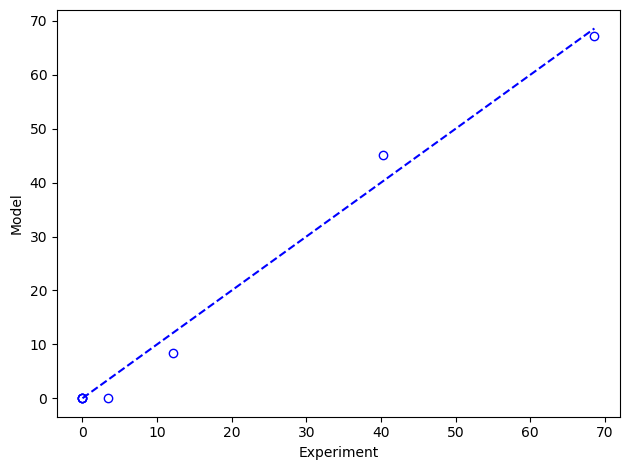

In [45]:
###### 1. Model
def model(x,*parameters):
    
    ### Independent variables
    t = x

    ### Parameters to be fit
    t0 = parameters[0]
    kp = parameters[1]
    
    ### Calculate output value for each data point based on a model
    y = np.zeros(ndpts)
    for i,val in enumerate(t):
        if t[i] <= t0:
            y[i] = 0
        else:
            y[i] = -kp * mcat / V * (t[i] - t0)    
    
    return y

###### 2. Experimental data

XA_expt = XA_seq
t_expt  = np.array([0,0.083333333,0.25,0.5,1,2,4,6])
mcat   = 0.1
V      = 30/1000

y_expt = np.log(1-XA_expt/100)
ndpts = len(y_expt)

###### 3. Parameter guesses
t0_g = 0.5
kp_g = 0.1
guess = [t0_g,kp_g]
npars = len(guess)

###### 4. Regression
popt,pcov = curve_fit(model,t_expt,y_expt,guess,method='lm')

### Confidence intervals
alpha = 0.05 # 95% confidence interval
dof = max(0,ndpts-npars) # number of degrees of freedom

tval = tdist.ppf(1.0-alpha/2.0,dof) # student t value for the dof and confidence level

ci = np.zeros([npars,2])
for i,p,var in zip(range(ndpts),popt,np.diag(pcov)):
    sigma = var**0.5
    ci[i,:] = [p-sigma*tval,p+sigma*tval]
ci_width = ci[:,1]-ci[:,0]

### Create output dataframe
param_names = ['t0','kp']
t0,kp = popt
soln = pd.DataFrame(popt,index=param_names,columns=['Value'])
soln['95% CI Half Width'] = ci_width/2
soln['95% CI Half Width Rel %'] = ci_width/2/popt*100

pd.options.display.float_format = "{:,.3e}".format
print('\n', soln, '\n')


## Parity plots

XA_predict = 100 * (1-np.exp(model(t_expt,*popt)))

# Parity line
x_parity = [min([min(XA_expt),min(XA_predict)]),max([max(XA_expt),max(XA_predict)])]
y_parity = [min([min(XA_expt),min(XA_predict)]),max([max(XA_expt),max(XA_predict)])]
    
# Plot data
fig = plt.figure()
ax1 = plt.subplot(111)

ax1.plot(XA_expt,XA_predict,'ob',mfc='none')
ax1.plot(x_parity,y_parity,'--b')
ax1.set_xlabel('Experiment')
ax1.set_ylabel('Model')

fig.tight_layout()

plt.show()

In [44]:
XA_Au_SiO2   = np.array([0,0,0,0,2.823543655,4.355452154,8.771968251,22.35485046])
XA_PdAu_SiO2 = np.array([0,0,0,0,1.898775994,7.348941705,21.27465065,46.60708032])
XA_Au_MgO    = np.array([0,0,0,0,3.288393782,8.588082902,25.68674481,40.48549099])
XA_PdAu_MgO  = np.array([0,0,0,1.736372271,7.516955249,20.54429715,49.51031231,68.35636984])
XA_MgO       = np.array([0,0,0,0,0,5.621878653,6.596472558,6.938541862])
XA_mix       = np.array([0,0,1.344341005,4.254123955,10.55963898,30.66100835,61.26200553,77.62967024])
XA_seq       = np.array([0,0,0,0,3.3698439,12.18638389,40.33438296,68.60792137])